In [34]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import albumentations as alb
import cv2

### 2.2 Limit GPU Memory Growth

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2.3 Load Image into TF Data Pipeline

In [7]:
data_wd = Path('/data') / 'raspi_face_detection'
img_path = data_wd / 'images'
labels_path = data_wd / 'labels'

In [8]:
images = tf.data.Dataset.list_files(f'{img_path}/*.jpg', shuffle=False)

2024-05-08 11:58:53.226026: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 11:58:53.228007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-08 11:58:53.228266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-08 11:58:53.228431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

In [9]:
images.as_numpy_iterator().next()

b'/data/raspi_face_detection/images/1a0378f0-0d58-11ef-abd8-dca632a68397.jpg'

In [10]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [11]:
images = images.map(load_image)

In [12]:
images.as_numpy_iterator().next()

array([[[163, 170, 176],
        [163, 170, 176],
        [164, 171, 177],
        ...,
        [162, 158, 159],
        [162, 158, 159],
        [162, 158, 159]],

       [[163, 170, 176],
        [163, 170, 176],
        [164, 171, 177],
        ...,
        [162, 158, 159],
        [162, 158, 159],
        [162, 158, 159]],

       [[162, 169, 175],
        [163, 170, 176],
        [163, 170, 176],
        ...,
        [162, 158, 159],
        [162, 158, 159],
        [162, 158, 159]],

       ...,

       [[102, 101,  96],
        [103, 104,  98],
        [ 97, 100,  93],
        ...,
        [  9,   9,   7],
        [ 11,  11,   9],
        [ 15,  15,  13]],

       [[101, 100,  95],
        [103, 104,  98],
        [ 99, 101,  96],
        ...,
        [  8,   8,   6],
        [  8,   8,   6],
        [ 11,  11,   9]],

       [[101, 100,  95],
        [104, 105,  99],
        [101, 103,  98],
        ...,
        [ 10,  10,   8],
        [  9,   9,   7],
        [ 10,  10,   8]]

In [13]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

In [14]:
image_generator = images.batch(4).as_numpy_iterator()

In [15]:
plot_images = image_generator.next()

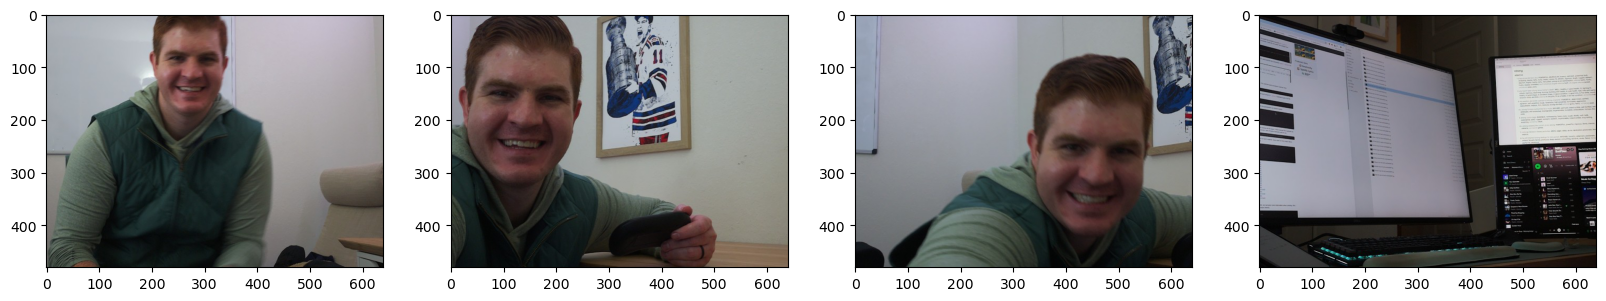

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

#### 3.1.1 Find Errors Where x/y-Max < x/y-min

In [39]:
errors = list()

augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                         bbox_params=alb.BboxParams(format='albumentations', 
                                                    label_fields=['class_labels']))

EMPTY_PHOTOS = ['de1c5f22-0cbd-11ef-9a53-dca632a68397', 'dce7e950-0cbd-11ef-9a53-dca632a68397', '22814110-0d58-11ef-abd8-dca632a68397', 'dbb39962-0cbd-11ef-9a53-dca632a68397']

fns = list(img_path.glob('*'))
for fn in fns:
    stem = fn.stem

    if stem in EMPTY_PHOTOS:
        continue
    
    img_fn   = img_path / f'{stem}.jpg'
    label_fn = labels_path / f'{stem}.json'
    
    
    img = cv2.imread(str(img_fn))
    with open(label_fn, 'r') as f:
        label = json.load(f)
    
    shapes = label['shapes']
    for shape in shapes:
        coords = [0,0,0,0]
        points = shape['points']
        coords[0] = points[0][0]
        coords[1] = points[0][1]
        coords[2] = points[1][0]
        coords[3] = points[1][1]
        coords = list(np.divide(coords, [640,480,640,480]))
    
        try:
            augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
        except ValueError:
            errors.append([stem, shape['label']])

print(len(errors))

0


In [40]:
print(pd.DataFrame(errors).to_csv())

""



### 3.1.1 Programmatically Split Data into Train/Test/Val

In [41]:
from sklearn.model_selection import train_test_split
import json
import pandas as pd
import shutil

In [42]:
labels = list()
for label_fn in labels_path.glob('*'):
    with open(label_fn, 'r') as f:
        label_json = json.load(f)
    labels.append(dict(
        image_path=Path(label_json['imagePath']).name,
        labels=', '.join(sorted([x['label'] for x in label_json['shapes']]))
    ))

In [43]:
df_labels = pd.DataFrame(labels)
df_labels.labels.value_counts()

labels
brendan          95
kara             51
brendan, kara     9
Name: count, dtype: int64

In [44]:
train, test = train_test_split(df_labels, test_size=0.3, random_state=42, stratify=df_labels.labels)
test, val = train_test_split(test, test_size=0.5, random_state=42, stratify=test.labels)

In [45]:
print('Training Set')
print(train.labels.value_counts().to_string(header=False))
print('\nTest Set')
print(test.labels.value_counts().to_string(header=False))
print('\nValidation Set')
print(val.labels.value_counts().to_string(header=False))

Training Set
brendan          66
kara             36
brendan, kara     6

Test Set
brendan          14
kara              7
brendan, kara     2

Validation Set
brendan          15
kara              8
brendan, kara     1


In [46]:
model_sets_files = dict(
    train=train.image_path.tolist(),
    test=test.image_path.tolist(),
    val=val.image_path.tolist(),
)
print('Model Set Percentages Check')
print({k: len(v) for k, v in model_sets_files.items()})
print({k: len(v) / len(df_labels) for k, v in model_sets_files.items()})

Model Set Percentages Check
{'train': 108, 'test': 23, 'val': 24}
{'train': 0.6967741935483871, 'test': 0.14838709677419354, 'val': 0.15483870967741936}


### 3.2 Moving Images and Labels

In [47]:
model_sets_path = data_wd / 'model_sets'

In [48]:
list(model_sets_path.glob('*'))

[PosixPath('/data/raspi_face_detection/model_sets/val'),
 PosixPath('/data/raspi_face_detection/model_sets/train'),
 PosixPath('/data/raspi_face_detection/model_sets/test')]

In [49]:
folder = 'train'
model_set_filepath = model_sets_path / folder
model_set_filepath_images = model_set_filepath / 'images'
model_set_filepath_labels = model_set_filepath / 'labels'
for p in [model_set_filepath, model_set_filepath_images, model_set_filepath_labels]:
    p.mkdir(exist_ok=True)

In [50]:
for folder in ['train','test','val']:
    model_set_filepath = model_sets_path / folder
    model_set_filepath_images = model_set_filepath / 'images'
    model_set_filepath_labels = model_set_filepath / 'labels'
    for p in [model_set_filepath, model_set_filepath_images, model_set_filepath_labels]:
        p.mkdir(exist_ok=True)

    for img_filename in model_sets_files[folder]:
        src_img_filepath, dst_img_filepath = [p / img_filename for p in [img_path, model_set_filepath_images]]
        shutil.copyfile(src_img_filepath, dst_img_filepath)
        
        label_filename = img_filename.split('.')[0]+'.json'
        src_label_filepath, dst_label_filepath = [p / label_filename for p in [labels_path, model_set_filepath_labels]]
        shutil.copyfile(src_label_filepath, dst_label_filepath)